## Import Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# Loading the dataset 
df = pd.read_csv("index.csv")
df

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.70,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.70,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.70,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.90,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.70,Latte
...,...,...,...,...,...,...
1128,2024-07-31,2024-07-31 20:53:35.077,card,ANON-0000-0000-0443,23.02,Cortado
1129,2024-07-31,2024-07-31 20:59:25.013,card,ANON-0000-0000-0040,27.92,Americano with Milk
1130,2024-07-31,2024-07-31 21:26:26.000,card,ANON-0000-0000-0444,32.82,Latte
1131,2024-07-31,2024-07-31 21:54:11.824,card,ANON-0000-0000-0445,32.82,Latte


### # ---1. Data Preparation & 2. Feature Engineering ---

In [5]:
# Converting 'datetime' to datetime objects for potential time-based features
df["datetime"] = pd.to_datetime(df["datetime"])

In [6]:
# Aggregating data by customer(Card)
customer_data = df.groupby("card").agg(
    total_spent = ("money","sum"),
    num_transactions = ("card","count")
).reset_index()

In [9]:
# Calculating average transaction value
customer_data["avg_transaction_value"] = customer_data["total_spent"] / customer_data["num_transactions
"]

In [10]:
# Featuring for coffee prefrences (Pivot table for money spent on each coffee type)
coffee_pivot = df.pivot_table(index = "card", columns = "coffee_name", values = "money", aggfunc = "sum", fill_value = 0)
coffee_pivot = coffee_pivot.div(coffee_pivot.sum(axis=1), axis=0)  # Converting to proportions

In [12]:
# Mearging all customer features
customer_features = pd.merge(customer_data, coffee_pivot, on="card", how="left")


In [13]:
# Handling potential NaN values if a customer didn't buy certain coffee types
customer_features = customer_features.fillna(0)

In [14]:
# Selecting features for clustering
features_for_clustering = customer_features.drop("card", axis=1)

In [16]:
# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)
scaled_features_df = pd.DataFrame(scaled_features, columns=features_for_clustering.columns)

### #---3. Model Selection (K-Means) & 4. Model Traning ---

In [17]:
# Determining optional K using Elbow Method (Conceptual)
inertia = []
for k in range (1,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

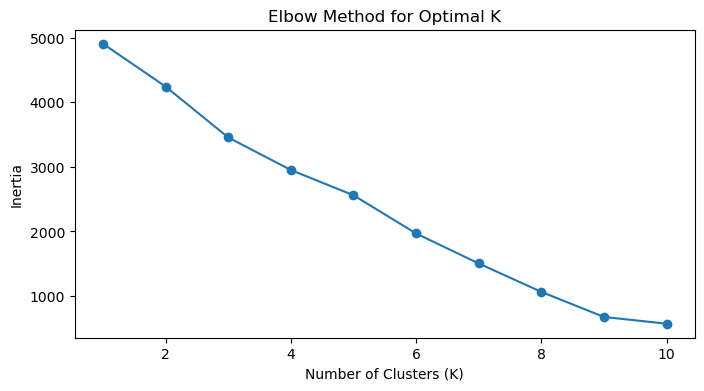

In [19]:
plt.figure(figsize=(8,4))
plt.plot(range(1,11), inertia, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()

In [20]:
# Let's assume optinal K is 3 for demonstration purposes
optional_k = 3
kmeans = KMeans(n_clusters = optional_k, random_state=42, n_init=10)
customer_features["cluster"] = kmeans.fit_predict(scaled_features)

### # ---5. Model Evolution and Interpretation ---

In [22]:
# Analysing cluster centroids
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features_for_clustering.columns)
print("Cluster Centroids (Unscaled Features):")
print(cluster_centers_df)

Cluster Centroids (Unscaled Features):
   total_spent  num_transactions  avg_transaction_value  Americano  \
0  2402.940000         75.500000              32.295088   0.213444   
1    61.634581          2.093596              28.847923   0.225066   
2    70.560913          1.941909              36.506047   0.010140   

   Americano with Milk  Cappuccino     Cocoa   Cortado      Espresso  \
0             0.276061    0.119457  0.008524  0.093759  3.380791e-02   
1             0.454011    0.009500  0.008622  0.152864  1.211267e-01   
2             0.031108    0.349400  0.054779  0.017809 -6.938894e-17   

   Hot Chocolate     Latte  
0       0.060550  0.194397  
1       0.008731  0.020079  
2       0.139429  0.397335  


In [23]:
# Counting customers in each cluster
print("\nCustomers per Cluster:")
print(customer_features["cluster"].value_counts())


Customers per Cluster:
cluster
2    241
1    203
0      2
Name: count, dtype: int64


In [24]:
# Visualizing clusters (using PCA for dimensionality reduction)
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(scaled_features)
principal_df = pd.DataFrame(data=principal_components, columns=["principal_component_1","principal_component_2"])
principal_df["cluster"] = customer_features["cluster"]

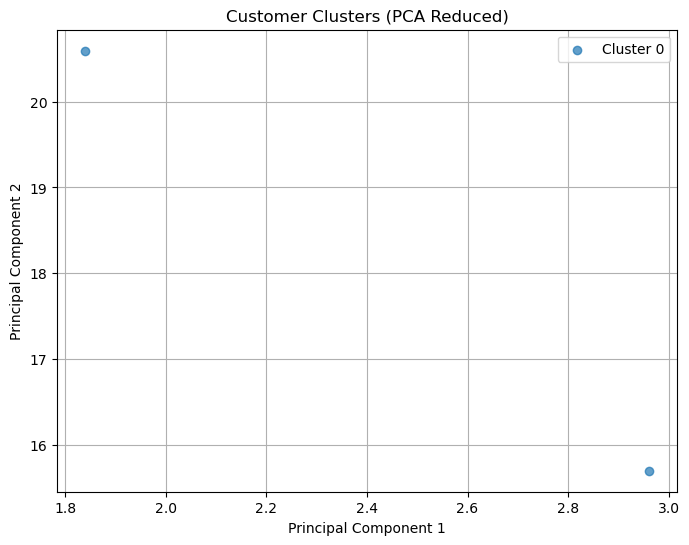

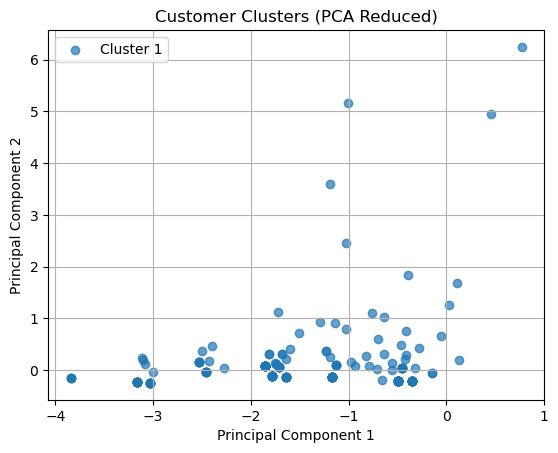

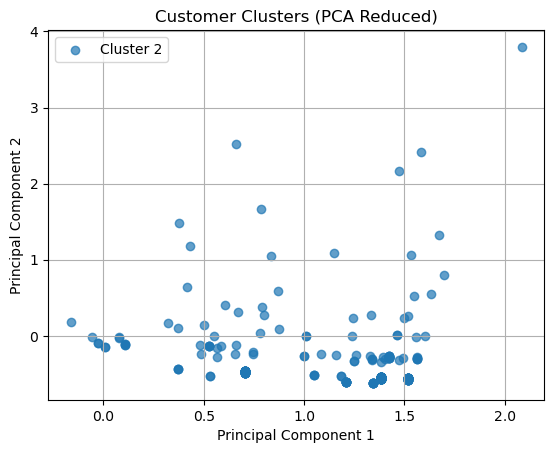

In [25]:
plt.figure(figsize=(8, 6))
for cluster_id in sorted(principal_df["cluster"].unique()):
    subset = principal_df[principal_df["cluster"]==cluster_id]
    plt.scatter(subset["principal_component_1"], subset["principal_component_2"],label=f'Cluster {cluster_id}', alpha=0.7)
    plt.title("Customer Clusters (PCA Reduced)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
# Detailed analysis of each cluster
# You can also look at the top coffee prefrences for each cluster
optimal_k = 4

for i in range(optimal_k):
    print(f"\n--- Cluster {i} Characteristics ---")
    cluster_subset = customer_features[customer_features["cluster"] == i]
    print(cluster_subset.describe())


--- Cluster 0 Characteristics ---
       total_spent  num_transactions  avg_transaction_value  Americano  \
count     2.000000           2.00000               2.000000   2.000000   
mean   2402.940000          75.50000              32.295088   0.213444   
std     269.039988          17.67767               3.998171   0.301856   
min    2212.700000          63.00000              29.467955   0.000000   
25%    2307.820000          69.25000              30.881521   0.106722   
50%    2402.940000          75.50000              32.295088   0.213444   
75%    2498.060000          81.75000              33.708655   0.320167   
max    2593.180000          88.00000              35.122222   0.426889   

       Americano with Milk  Cappuccino     Cocoa   Cortado  Espresso  \
count             2.000000    2.000000  2.000000  2.000000  2.000000   
mean              0.276061    0.119457  0.008524  0.093759  0.033808   
std               0.033504    0.001698  0.012054  0.040240  0.047812   
min       